# Distance-Based Embeddings on the Zachary Karate Club Network

This notebook illustrates the main ideas from the **distance-based embedding** lecture using the classic **Zachary Karate Club** network.

We will:

1. Load the Zachary network and visualize a standard **spring layout**.
2. Treat the spring layout as a (heuristic) embedding and build the $2\times n$ embedding matrix $X_2$ from node coordinates.
3. Define three graph-based pairwise distance matrices:
   - **Shortest-path distance**
   - **Flow-based distance** (based on max-flow / min-cut)
   - **Electrical resistance distance** (effective resistance via the Laplacian pseudoinverse)
4. Visualize each distance matrix as a heatmap.
5. Compute **2D embeddings** from each distance matrix using:
   - **Stress minimization** (via metric MDS with precomputed distances)
   - **Classical MDS** (via double-centering + eigendecomposition)
6. Build a **3D embedding** from the resistance distance and plot it.
7Build a **4D embedding** from the resistance distance and display a few columns of the $4\times n$ matrix $X_4$.

---

> **Note (pedagogical):** the spring layout is primarily a visualization heuristic; the distance-based embeddings below are derived from well-defined pairwise distances.


In [17]:
# Core imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Reproducibility
SEED = 8
rng = np.random.default_rng(SEED)

print("Imports loaded. SEED =", SEED)


Imports loaded. SEED = 8


## 1. Load the Zachary Karate Club graph

NetworkX provides the Zachary network as a built-in dataset. This graph is undirected and unweighted.

- Nodes represent members of a karate club.
- Edges represent friendships.
- The graph famously split into two factions (often used as a ground-truth community label).


In [18]:
G = nx.karate_club_graph()
n = G.number_of_nodes()
m = G.number_of_edges()

print(f"Zachary Karate Club graph: n={n}, m={m}, directed? {G.is_directed()}")

club = nx.get_node_attributes(G, "club")
unique_clubs = sorted(set(club.values()))
print("Club labels:", unique_clubs)


Zachary Karate Club graph: n=34, m=78, directed? False
Club labels: ['Mr. Hi', 'Officer']


## 2. Spring layout (visualization)

We start with the **spring layout** (force-directed layout). This produces coordinates in $\mathbb{R}^2$ that are convenient for visualization.

> Important: a spring layout is not derived from a graph distance matrix in a principled way, and it can vary with initialization and parameters.


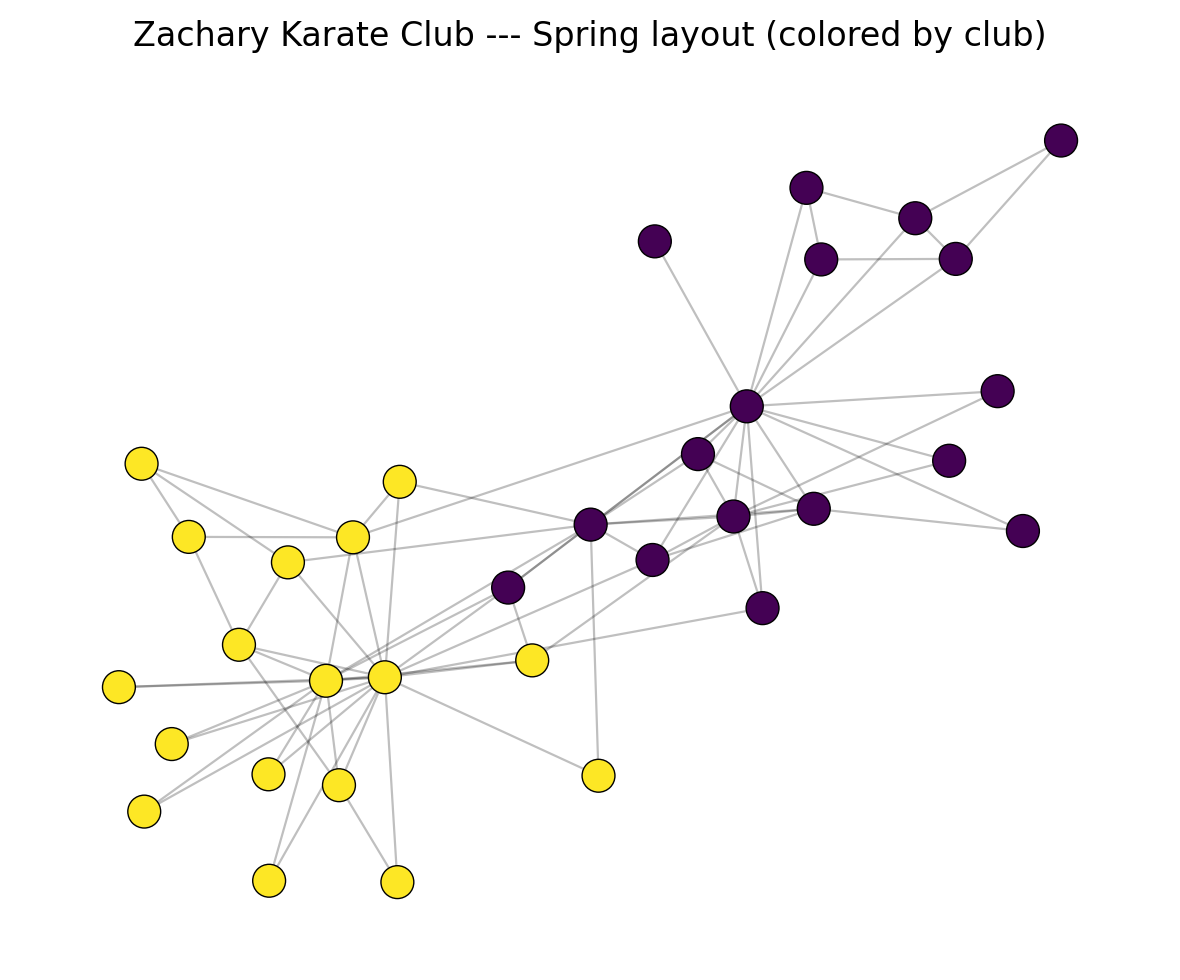

In [19]:
pos_spring = nx.spring_layout(G, seed=SEED)

# Color nodes by faction for visual reference (2 colors)
club_color = {"Mr. Hi": 0, "Officer": 1}
node_colors = [club_color[club[i]] for i in G.nodes()]

plt.figure(figsize=(6, 5), dpi=200)
nx.draw_networkx_edges(G, pos_spring, alpha=0.25, width=0.8)
nx.draw_networkx_nodes(G, pos_spring, node_color=node_colors, node_size=140, edgecolors="black", linewidths=0.5)
plt.title("Zachary Karate Club --- Spring layout (colored by club)")
plt.axis("off")
plt.tight_layout()
plt.show()


## 3. The $2\times n$ embedding matrix $X_2$ from the spring layout

Given a 2D layout with coordinates $\textbf{x}_i \in \mathbb{R}^2$ for each node $i$, we can assemble the embedding matrix

$$
X_2 = \begin{bmatrix} \textbf{x}_1 & \textbf{x}_2 & \cdots & \textbf{x}_n \end{bmatrix}\in\mathbb{R}^{2\times n}.
$$

Here the **columns** are the node coordinates on the plane.


In [25]:
# Assemble X2 with columns as node coordinates (ordered by node index)
X2_spring = np.vstack([[pos_spring[i][0] for i in range(n)],
                       [pos_spring[i][1] for i in range(n)]])

print("X2_spring shape:", X2_spring.shape)
print("First 8 columns of X2_spring:\n", np.round(X2_spring[:, :8], 4))


X2_spring shape: (2, 34)
First 8 columns of X2_spring:
 [[0.3412 0.3175 0.0642 0.46   0.4732 0.6401 0.7119 0.2546]
 [0.3386 0.0644 0.0443 0.0836 0.7041 0.8067 0.7055 0.2197]]


## 4. Build distance matrices from graph structure

We now construct three pairwise distance matrices $D=[d_{ij}]$:

1. **Shortest-path distance**: $d_{\mathrm{sp}}(i,j)$ equals the length of a shortest path.
2. **Flow-based distance**: define $f(i,j)$ as the maximum flow between $i$ and $j$ in a capacitated network.
   We then set a distance-like quantity as:
   $$
   d_{\mathrm{flow}}(i,j) = \frac{1}{f(i,j)}.
   $$
   (Large flow means nodes are “close”.)
3. **Electrical resistance distance** (effective resistance), which will be covered in more detail in coming sections.

All three produce symmetric matrices (for undirected graphs).


In [21]:
# ---------- 4.1 Shortest-path distance matrix ----------
lengths = dict(nx.all_pairs_shortest_path_length(G))
D_sp = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(n):
        D_sp[i, j] = lengths[i][j]

# ---------- 4.2 Flow-based distance matrix ----------
# Assign capacity 1 to each edge.
G_cap = G.copy()
for u, v in G_cap.edges():
    G_cap[u][v]["capacity"] = 1.0

flow_val = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(n):
        if i == j:
            flow_val[i, j] = np.inf
        else:
            flow_val[i, j] = nx.maximum_flow_value(
                G_cap, i, j, capacity="capacity", flow_func=nx.algorithms.flow.edmonds_karp
            )

D_flow = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(n):
        if i == j:
            D_flow[i, j] = 0.0
        else:
            D_flow[i, j] = 1.0 / flow_val[i, j]

# ---------- 4.3 Effective resistance distance matrix ----------
L = nx.laplacian_matrix(G).astype(float).toarray()
L_pinv = np.linalg.pinv(L)

D_res = np.zeros((n, n), dtype=float)
for i in range(n):
    ei = np.zeros(n); ei[i] = 1.0
    for j in range(n):
        ej = np.zeros(n); ej[j] = 1.0
        diff = ei - ej
        D_res[i, j] = diff @ L_pinv @ diff

print("Distance matrices built:")
print("  D_sp   range:", (D_sp.min(), D_sp.max()))
print("  D_flow range:", (D_flow.min(), D_flow.max()))
print("  D_res  range:", (D_res.min(), D_res.max()))


Distance matrices built:
  D_sp   range: (0.0, 5.0)
  D_flow range: (0.0, 1.0)
  D_res  range: (0.0, 0.7614008097261227)


## 5. Visualize the distance matrices

Heatmaps help us see the qualitative structure of each distance. Distances that align well with community structure often show a “blocky” pattern.


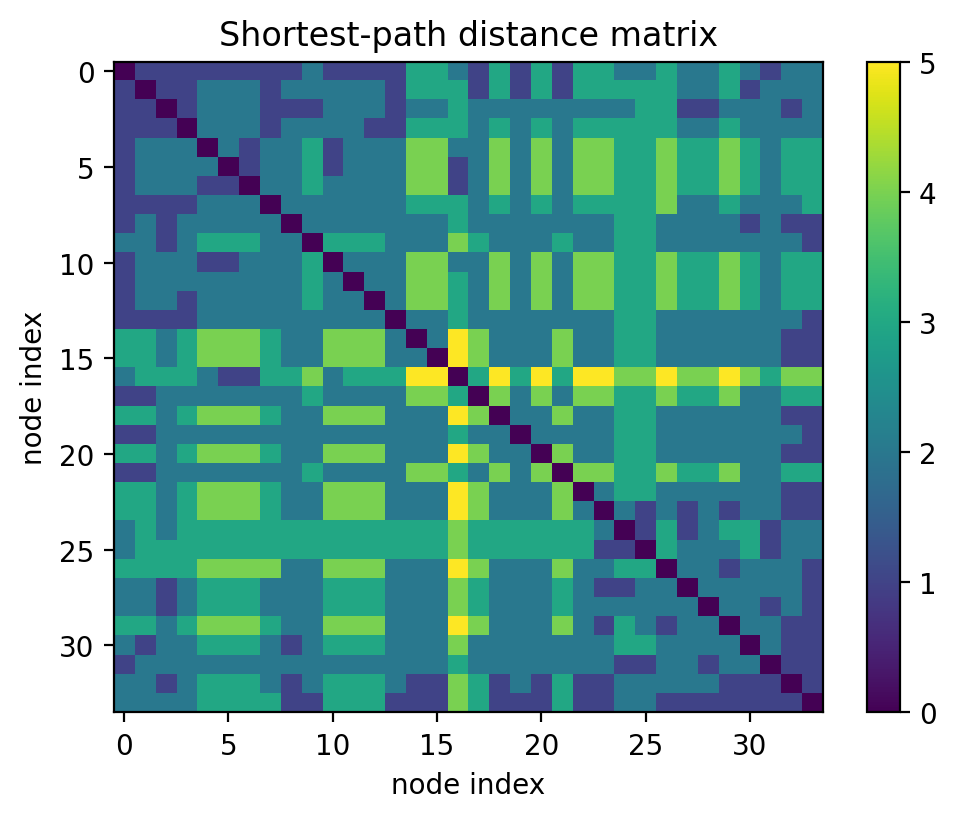

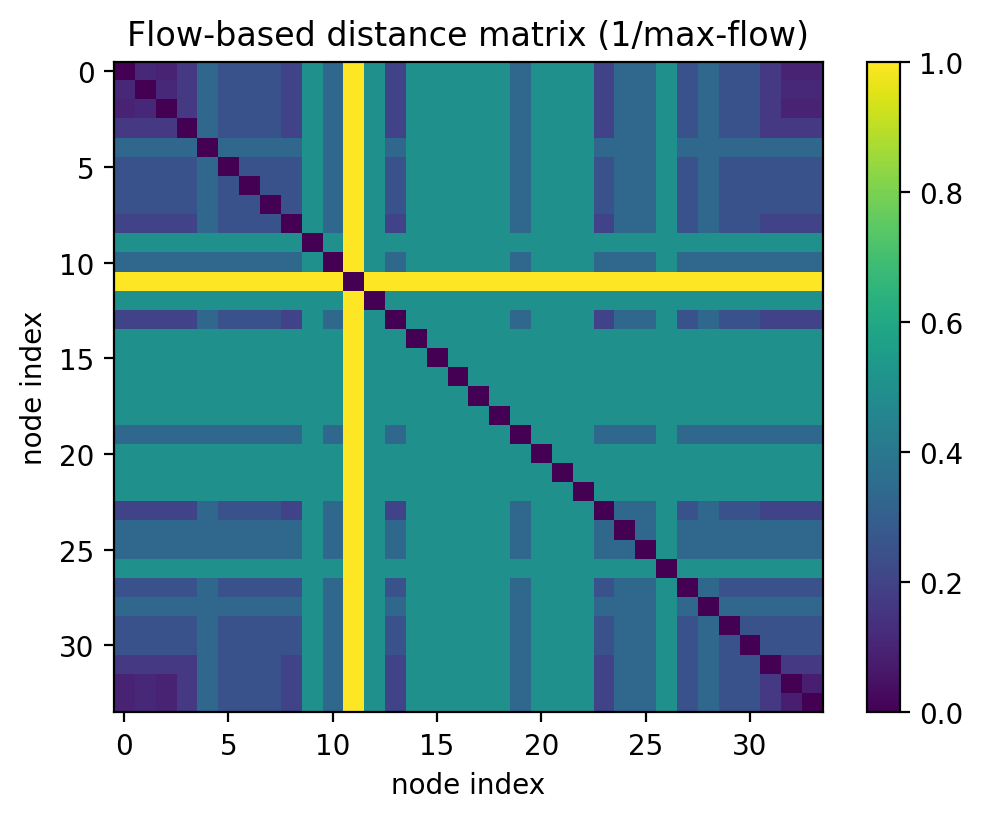

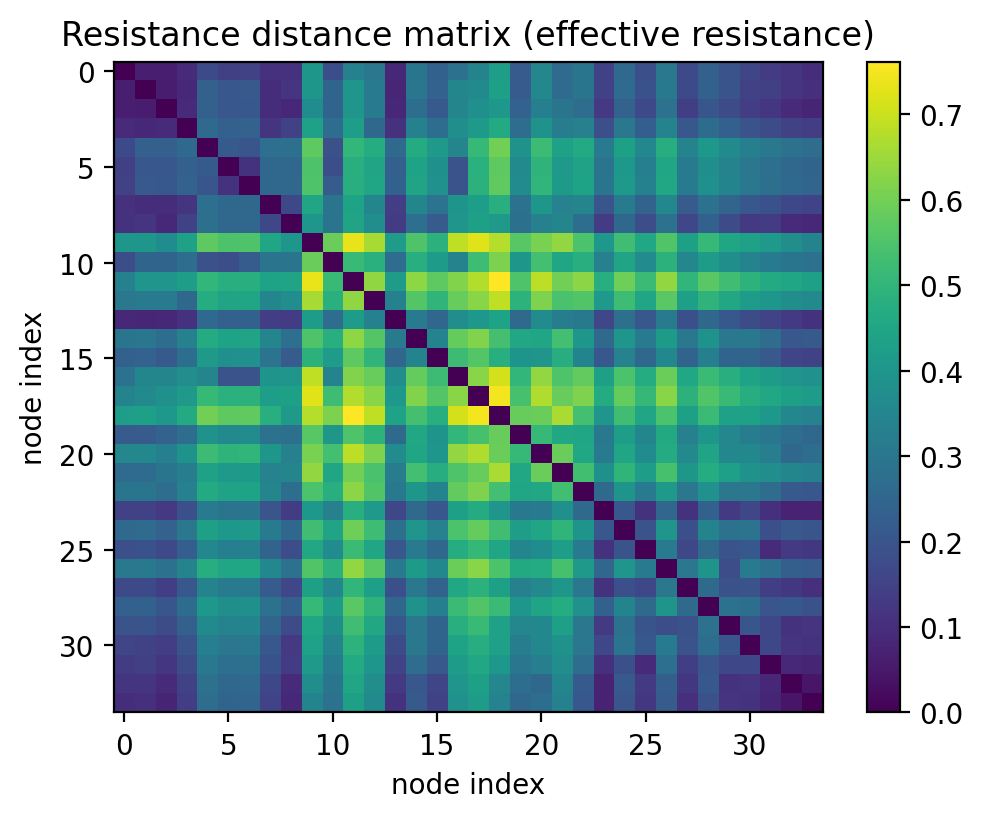

In [22]:
def show_heatmap(M, title):
    plt.figure(figsize=(5.2, 4.2), dpi=200)
    plt.imshow(M, aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("node index")
    plt.ylabel("node index")
    plt.tight_layout()
    plt.show()

show_heatmap(D_sp,  "Shortest-path distance matrix")
show_heatmap(D_flow,"Flow-based distance matrix (1/max-flow)")
show_heatmap(D_res, "Resistance distance matrix (effective resistance)")


## 6. Two embedding methods from distances

We compute 2D embeddings from each distance matrix using:

### A) Stress minimization (metric MDS)
We solve approximately:
$$
\min_{\textbf{x}_1,\ldots,\textbf{x}_n\in\mathbb{R}^2}\;\sum_{i<j}\big(\|\textbf{x}_i-\textbf{x}_j\|_2-d_{ij}\big)^2.
$$

We implement this using `sklearn.manifold.MDS` with `dissimilarity="precomputed"`.

### B) Classical MDS (double-centering)
Given $D^{(2)}=[d_{ij}^2]$, compute:
$$
G = -\tfrac12 H D^{(2)} H,\qquad H = I - \tfrac1n \mathbf{1}\mathbf{1}^\top,
$$
then take the top $d$ eigenpairs of $G$ to recover coordinates in $\mathbb{R}^d$.


In [27]:
def stress_mds_embedding(D, dim=2, seed=SEED):
    mds = MDS(
        n_components=dim,
        dissimilarity="precomputed",
        random_state=seed,
        normalized_stress="auto",
        n_init=4,
        max_iter=400,
    )
    X = mds.fit_transform(D)  # shape: (n, dim) as rows
    return X.T  # convert to (dim, n) with columns = node coordinates

def classical_mds_embedding(D, dim=2):
    n = D.shape[0]
    D2 = D**2
    H = np.eye(n) - (1.0/n) * np.ones((n, n))
    G = -0.5 * H @ D2 @ H
    evals, evecs = np.linalg.eigh(G)
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    evals_d = np.clip(evals[:dim], 0, None)
    evecs_d = evecs[:, :dim]  # (n, dim)
    X = (np.diag(np.sqrt(evals_d)) @ evecs_d.T)  # (dim, n)
    return X

dist_mats = {"Shortest path": D_sp, "Flow (1/maxflow)": D_flow, "Resistance": D_res}

X2_stress = {}
X2_cmds = {}

for name, D in dist_mats.items():
    X2_stress[name] = stress_mds_embedding(D, dim=2, seed=SEED)
    X2_cmds[name]   = classical_mds_embedding(D, dim=2)

print("Computed 2D embeddings for all three distances using both methods.")


Computed 2D embeddings for all three distances using both methods.


## 7. Compare embeddings in a $2\times 3$ grid

- Rows: **Stress minimization** vs **Classical MDS**
- Columns: **Shortest-path**, **Flow-based**, **Resistance**


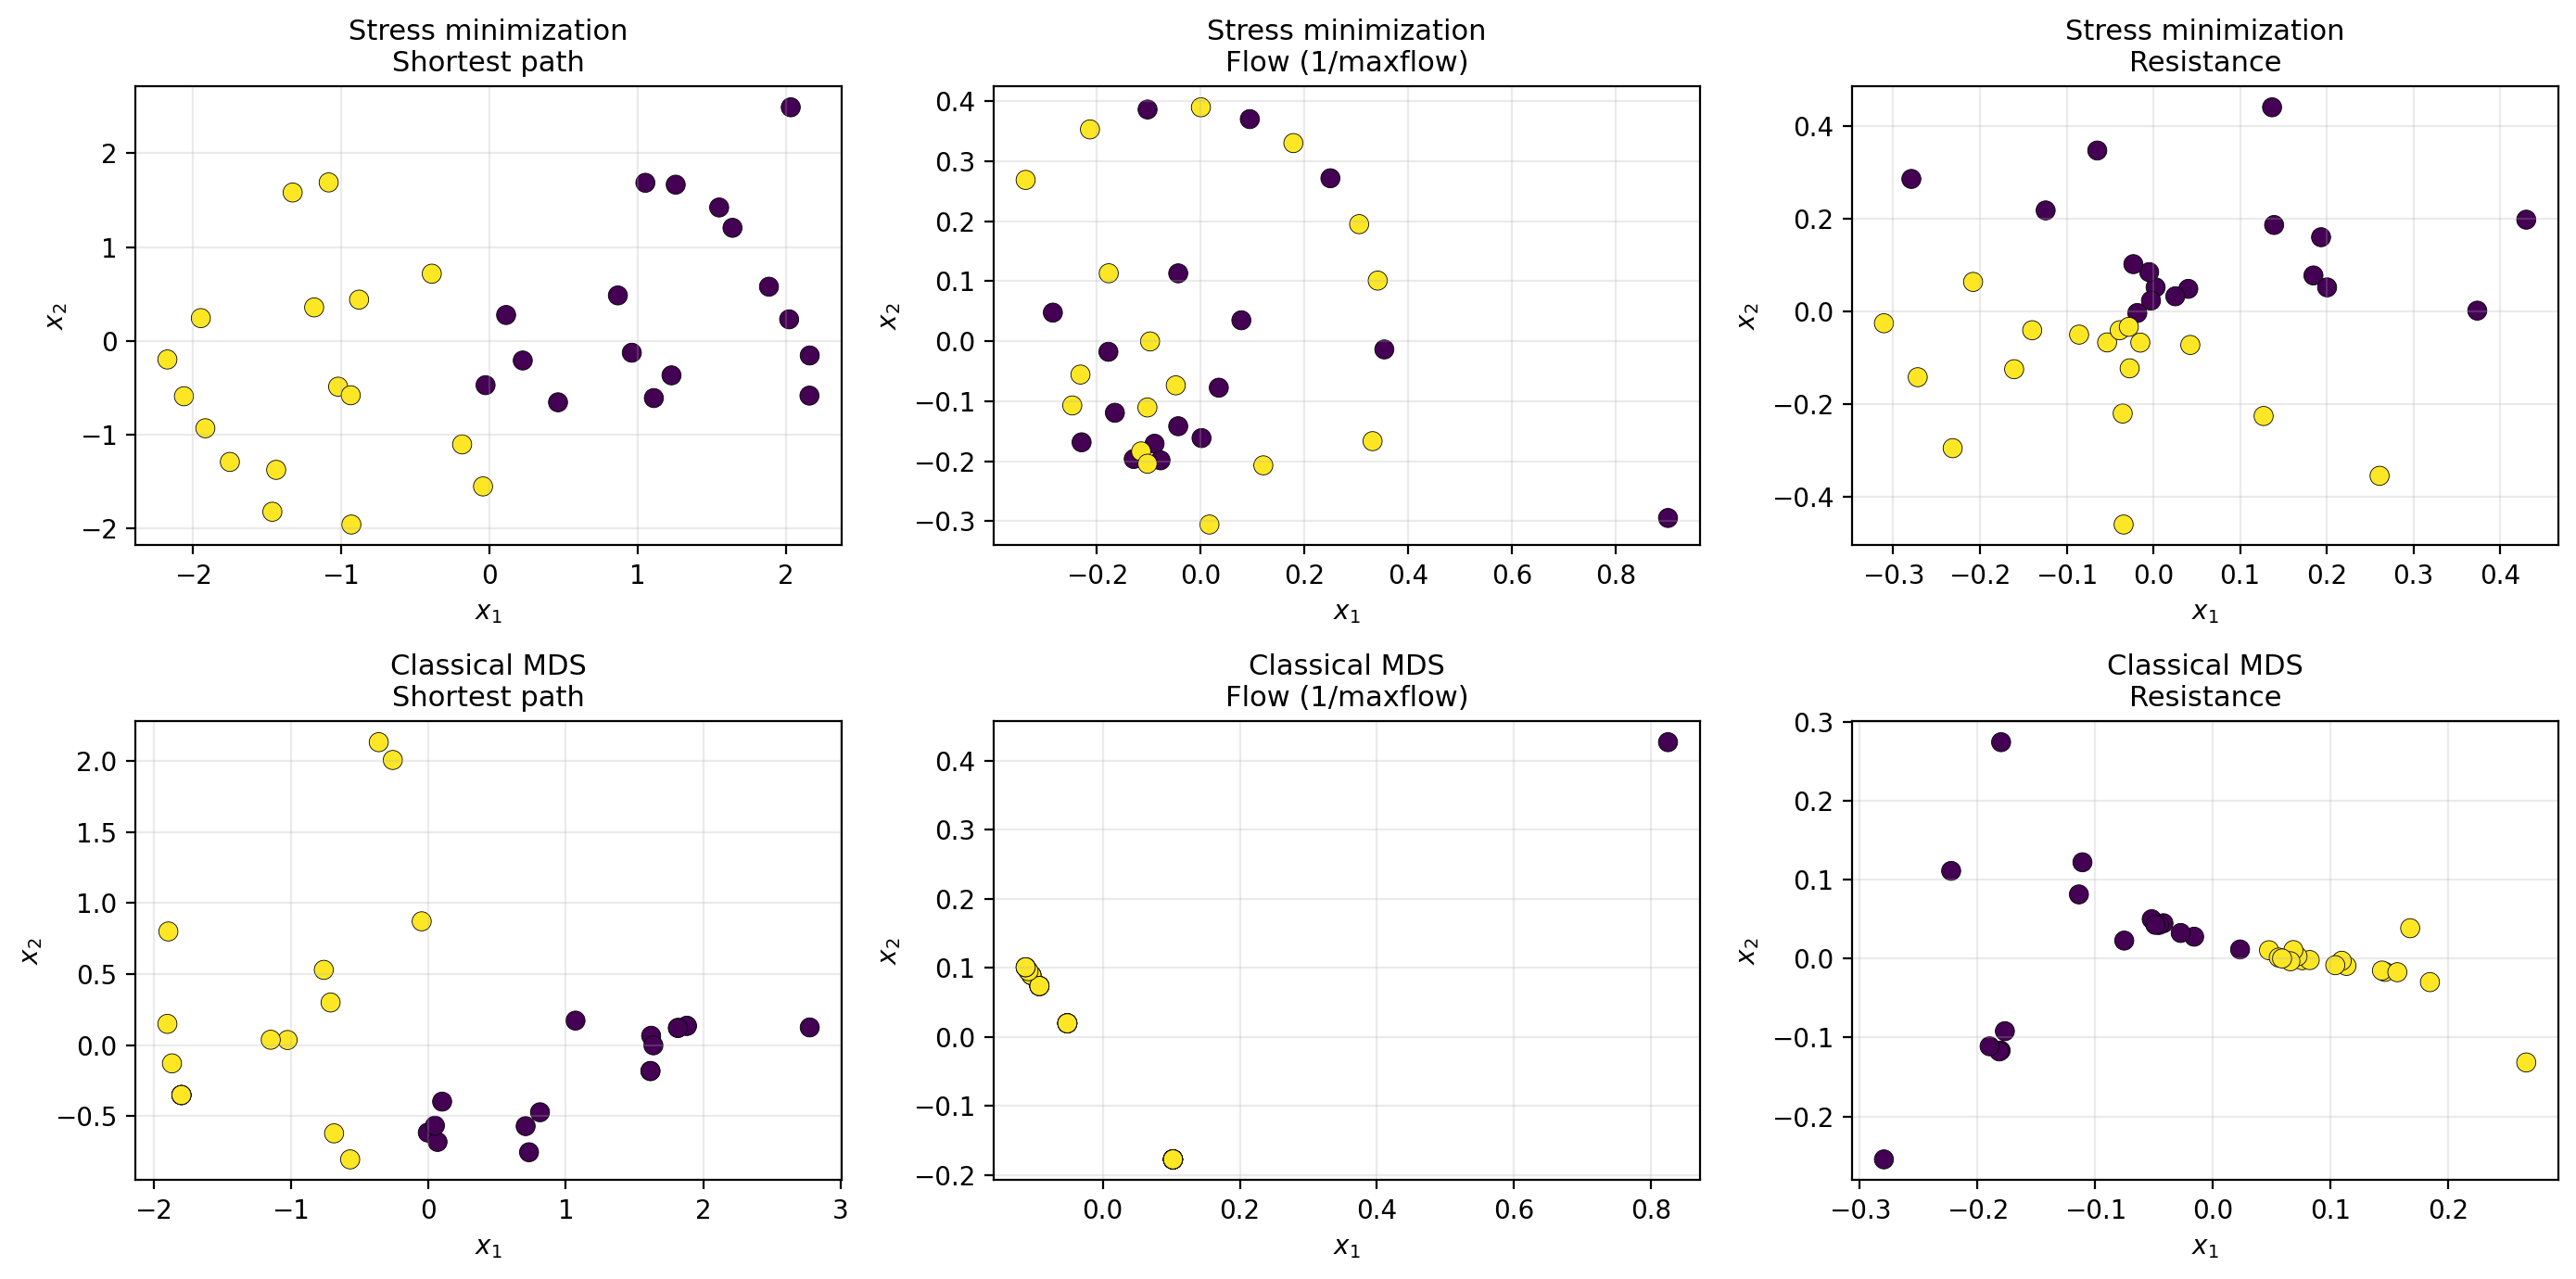

In [29]:
def plot_embedding(ax, X2, title):
    ax.scatter(X2[0, :], X2[1, :], c=node_colors, s=55, edgecolors="black", linewidths=0.3)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.grid(True, alpha=0.25)

fig, axes = plt.subplots(2, 3, figsize=(14, 7), dpi=200)

cols = list(dist_mats.keys())

for j, name in enumerate(cols):
    plot_embedding(axes[0, j], X2_stress[name], f"Stress minimization\n{name}")

for j, name in enumerate(cols):
    plot_embedding(axes[1, j], X2_cmds[name], f"Classical MDS\n{name}")

plt.tight_layout()
plt.show()


## 8. A 3D embedding from resistance distances

We compute a **3D classical MDS embedding** from the resistance distance matrix and visualize it.


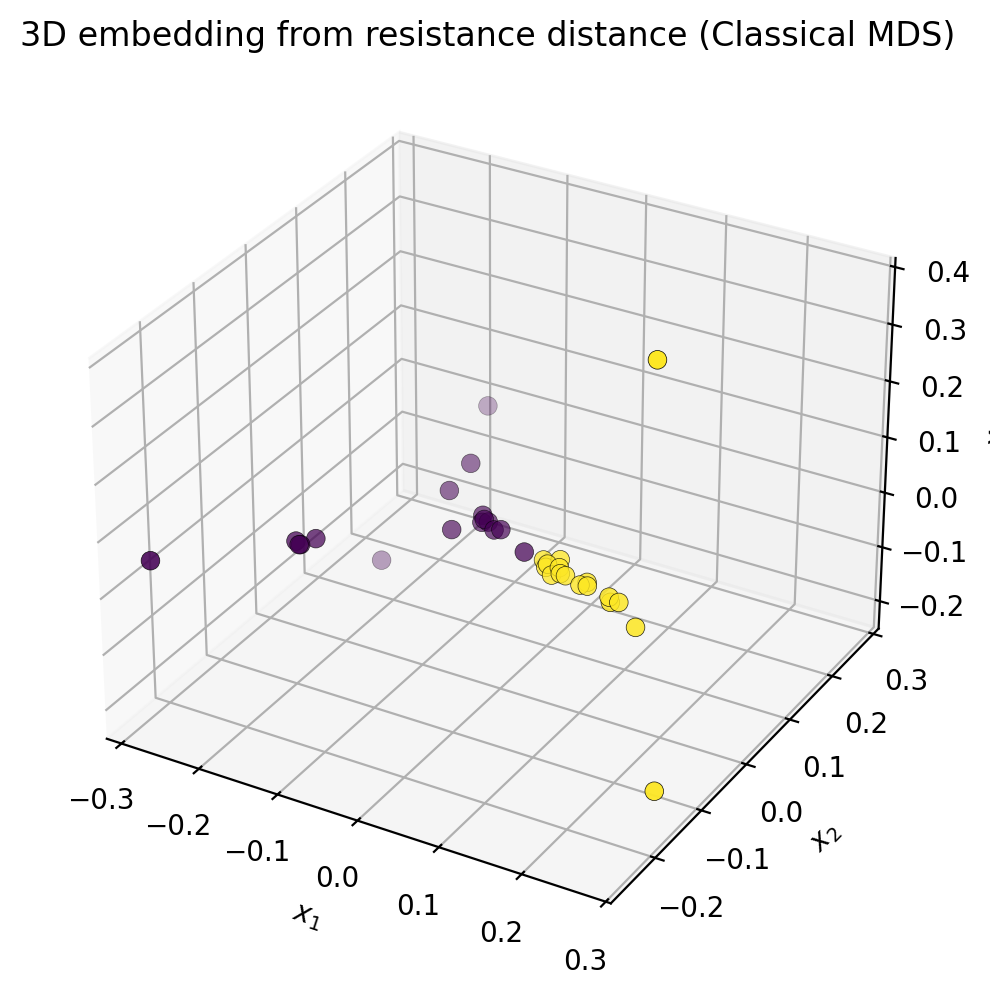

In [30]:
X3_res_cmds = classical_mds_embedding(D_res, dim=3)  # (3, n)

fig = plt.figure(figsize=(7, 5), dpi=200)
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X3_res_cmds[0, :], X3_res_cmds[1, :], X3_res_cmds[2, :],
           c=node_colors, s=45, edgecolors="black", linewidths=0.25)

ax.set_title("3D embedding from resistance distance (Classical MDS)")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")

plt.tight_layout()
plt.show()


## 9. A $4\times n$ embedding matrix $X_4$ from resistance distances

We compute a **4D classical MDS embedding** from the resistance distance matrix:
$$
X_4 \in \mathbb{R}^{4\times n}.
$$

We display the first few columns of $X_4$.


In [32]:
X4_res_cmds = classical_mds_embedding(D_res, dim=4)  # (4, n)

print("X4_res_cmds shape:", X4_res_cmds.shape)
print("First 8 columns of X4_res_cmds (rounded):\n", np.round(X4_res_cmds[:, :8], 4))


X4_res_cmds shape: (4, 34)
First 8 columns of X4_res_cmds (rounded):
 [[-0.0753 -0.042  -0.0159 -0.052  -0.1767 -0.1803 -0.1814 -0.0458]
 [ 0.0229  0.0449  0.0278  0.05   -0.0919 -0.1165 -0.1176  0.0427]
 [-0.0103  0.0008  0.0106  0.0052  0.0167  0.0229  0.0232  0.0056]
 [ 0.0107 -0.0068  0.0074  0.0026 -0.0145 -0.0201 -0.0204  0.0012]]


## Summary

In this notebook we:

- Compared a visualization embedding (spring layout) with embeddings derived from **graph distances**.
- Built three distance matrices: shortest-path, flow-based, and resistance distance.
- Computed 2D embeddings via **stress minimization** and **classical MDS**.
- Built higher-dimensional embeddings (3D and 4D) from resistance distances.

Next, we will study **clustering algorithms** that operate on these embeddings.
